In [3]:
#! /bin/env python3

import pickle

def load_pkl(fname):
	with open(fname,'rb') as f:
		return pickle.load(f)

def save_pkl(fname,obj):
	with open(fname,'wb') as f:
		pickle.dump(obj,f)


In [4]:
# Loading packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import skimage
import pandas as pd

# Loading in the train data
train_data = load_pkl('../train_data.pkl')

# Loading in the labels
train_labels = np.load('../finalLabelsTrain.npy')

# When attempting to only classify a and b, looking only at reduced set.
ab_train_data = train_data[np.logical_or((train_labels == 1),(train_labels == 2))]
ab_train_labels = train_labels[np.logical_or((train_labels == 1),(train_labels == 2))]

# It appears that in the original data, the letter switches after every count of 9

# List of a,b data points that need to be rotated - this is not used

rot_list = []
j = 0

for i in range(1600):
    if(np.shape(ab_train_data[i])[0] < np.shape(ab_train_data[i])[1]):
        rot_list.append(j)
    j = j + 1


# The list actually had many points that do not need to be rotated...

rot_list = [241,242,243,244,245,246,247,250,
           251,252,253,254,255,256,257,258,259,
           500,501,502,503,504,505,506,507,508,509,
           510,511,512,513,514,515,516,517,518,519]

# Some things should just be thrown out
trash_list = [240,248,249,960]

# Indices of interest
# 480 is an example of a well written "a" that was not automatically centered
#whatsoever. Many examples of this.

# Conclusions from above:

# Not actually that many bad data points. Possible I missed some since 
# I was going by every 10 then checking every one once I found a bad spot,
# but unlikely since the same individual does every ten
# There were many cases though where resizing is important.
# Every rotated image is solved by 270 degrees

# Rotating the above images by 270 degrees, seems to be the only way things went wrong
for index in rot_list:
    img = (ab_train_data[index])
    lx, ly = img.shape
    rot_img = ndimage.rotate(img, 270)
    ab_train_data[index] = rot_img

# For every image we resize to (50,50)
for i in range(1600):
    ab_train_data[i] = skimage.transform.resize(np.asarray(ab_train_data[i]), (50,len(np.array(ab_train_data[i])[0,:])))

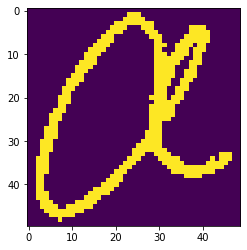

In [33]:
plt.imshow(ab_train_data[0])

In [163]:
def get_measurements(img):
    
    yaxis = pd.Series([np.count_nonzero(img[i,:])*[i+1] 
           for i in np.arange(np.shape(img)[0])], name='yaxis').explode()
    xaxis = pd.Series([np.count_nonzero(img[:,i])*[i+1] 
           for i in np.arange(np.shape(img)[1])], name='xaxis').explode()   
    
    yrange = (np.max(yaxis) - np.min(yaxis))
    xrange = (np.max(xaxis) - np.min(xaxis))   
    
    rangediff = abs(yrange - xrange)
    
    return yaxis, xaxis, rangediff

In [164]:
b = []
a = []

for i in list(enumerate(ab_train_labels)):
    if i[1] == 2:
        b.append(i[0])
    elif i[1] == 1:
        a.append(i[0])
        
b_data = ab_train_data[b]
a_data = ab_train_data[a]

In [564]:
byaxis=[]
bxaxis=[]
brangediff=[]
byargmax=[]
bxargmax=[]
bxaxismed=[]
bxstreak=[]

for bimg in b_data:
    
    yaxis, xaxis, rangediff = get_measurements(bimg)
    
    byarg = yaxis.reset_index().groupby('yaxis').count().values.argmax()
    bxarg = xaxis.reset_index().groupby('xaxis').count().values.argmax()
    
    bxstreak.append(xaxis.reset_index().groupby('xaxis').count().max().values[0])
    
    byargmax.append(byarg)
    bxargmax.append(bxarg)
    
    byaxis.append(yaxis)
    bxaxis.append(xaxis)
    brangediff.append(rangediff)
    bxaxismed.append(xaxis.median())

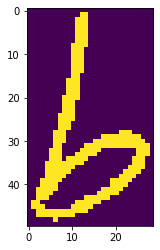

In [458]:
plt.imshow(b_data[0])

In [667]:
bstreaky=[]
for b in b_data:
    bstreaky.append(pd.Series([np.count_nonzero(b[:,i])*[i+1] 
           for i in np.arange((np.shape(b)[1])-5,(np.shape(b)[1]))], name='yaxis').explode().reset_index(
         ).groupby('yaxis').count().max()[0])

(array([49.,  1.,  1.,  3.,  7., 12., 11., 11., 21., 28., 30., 51., 67.,
        71., 85., 68., 54., 65., 53., 41., 24., 22.,  9.,  6.,  3.,  2.,
         0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

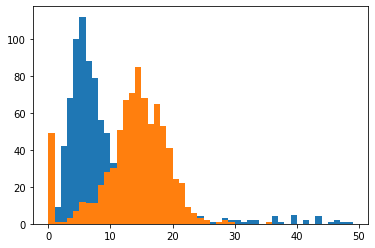

In [668]:
plt.hist(pd.Series(astreaky).fillna(0), bins=np.arange(0,50,1))
plt.hist(pd.Series(bstreaky).fillna(0), bins=np.arange(0,50,1))

In [651]:
pd.Series(astreaky).fillna(0)

0      5.0
1      4.0
2      4.0
3      4.0
4      7.0
      ... 
795    5.0
796    8.0
797    6.0
798    8.0
799    6.0
Length: 800, dtype: float64

In [680]:
np.count_nonzero(pd.Series(astreaky).fillna(0) > np.quantile(pd.Series(bstreaky).fillna(0), .25))/800

np.count_nonzero(pd.Series(astreaky).fillna(0) < 1)/800
np.count_nonzero(pd.Series(bstreaky).fillna(0) < 1)/800

0.06125

In [641]:
astreaky=[]
for a in a_data:
    astreaky.append(pd.Series([np.count_nonzero(a[:,i])*[i+1] 
           for i in np.arange((np.shape(a)[1]-5), np.shape(a)[1])], name='yaxis').explode().reset_index(
         ).groupby('yaxis').count().max()[0])

(array([ 11.,  24.,  22.,  28.,  89., 137., 174., 152., 119.,  44.]),
 array([ 8. , 12.1, 16.2, 20.3, 24.4, 28.5, 32.6, 36.7, 40.8, 44.9, 49. ]),
 <a list of 10 Patch objects>)

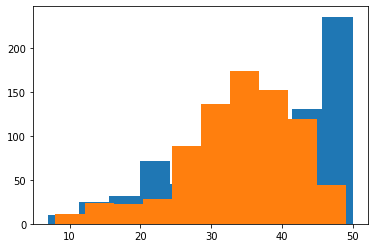

In [567]:
plt.hist(bxstreak)
plt.hist(axstreak)

(array([ 43., 226., 196., 132.,  78.,  43.,  29.,  11.,   8.,  14.,   3.,
          3.,   4.,   1.,   0.,   2.,   0.,   2.,   2.,   0.,   2.,   1.,
          0.,   0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <a list of 24 Patch objects>)

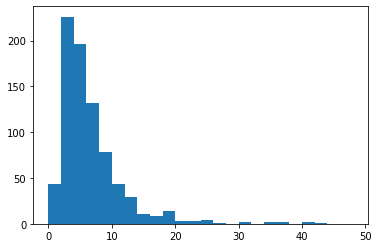

In [166]:
plt.hist(bxargmax, bins=np.arange(0,50,2))

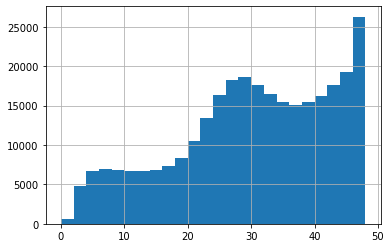

In [154]:
pd.concat(byaxis).hist(bins=np.arange(0,50,2))

In [236]:
pd.concat(bxaxis).median()
#pd.concat(axaxis).median()

12.0

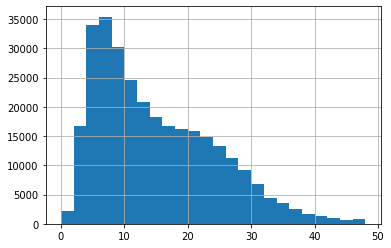

In [155]:
pd.concat(bxaxis).hist(bins=np.arange(0,50,2))

(array([0.2825  , 0.101875, 0.0325  , 0.020625, 0.024375, 0.0125  ,
        0.008125, 0.005625, 0.00375 , 0.001875, 0.003125, 0.001875,
        0.000625, 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.000625, 0.      , 0.      , 0.      , 0.      , 0.      ]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <a list of 24 Patch objects>)

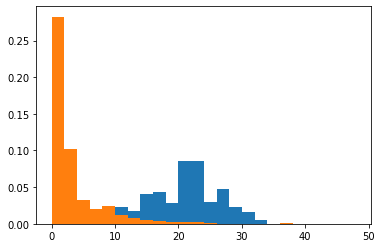

In [438]:
plt.hist(brangediff,bins=np.arange(0,50,2),density=True)
plt.hist(arangediff,bins=np.arange(0,50,2),density=True)

In [565]:
ayaxis=[]
axaxis=[]
arangediff=[]
ayargmax=[]
axargmax=[]
axaxismed=[]
axstreak=[]

for aimg in a_data:
    
    yaxis, xaxis, rangediff = get_measurements(aimg)
        
    ayarg = yaxis.reset_index().groupby('yaxis').count().values.argmax()
    axarg = xaxis.reset_index().groupby('xaxis').count().values.argmax()
    
    axstreak.append(xaxis.reset_index().groupby('xaxis').count().max().values[0])
    
    ayargmax.append(ayarg)
    axargmax.append(axarg)
    
    ayaxis.append(yaxis)
    axaxis.append(xaxis)
    axaxismed.append(xaxis.median())
    arangediff.append(rangediff)

(array([ 8., 71., 56., 23., 18., 16., 11.,  8.,  9., 21., 22., 53., 67.,
        92., 94., 80., 69., 39., 18., 12.,  7.,  4.,  2.,  0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <a list of 24 Patch objects>)

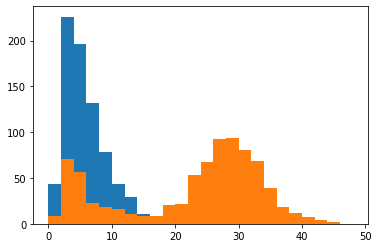

In [378]:
plt.hist(bxargmax, bins=np.arange(0,50,2))
plt.hist(axargmax, bins=np.arange(0,50,2))

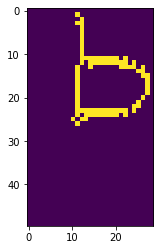

In [441]:
plt.imshow(b_data[np.array(brangediff) < 10][1])

In [443]:
b_data[np.array(brangediff) < 10][1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [381]:
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
bxargmax_trans = quantile_transformer.fit_transform(X[:,2:])
quantile_transformer.quantiles_ 

array([[ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       ...,
       [33.       , 42.7987988],
       [34.1981982, 43.3993994],
       [37.       , 45.       ]])

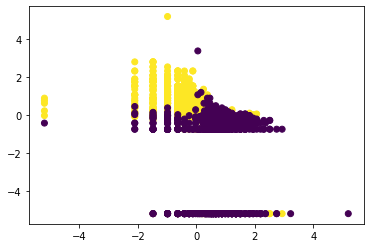

In [384]:
plt.scatter(x=bxargmax_trans[:,1], y=bxargmax_trans[:,0], c=y)

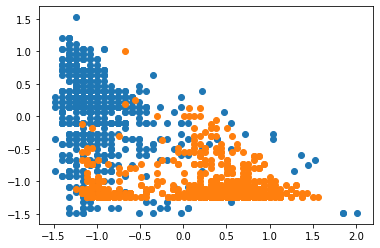

In [411]:
plt.scatter(x=((bcoords-bcoords.mean())/bcoords.std())[:,0],y=((bcoords-bcoords.mean())/bcoords.std())[:,1])
plt.scatter(x=((acoords-acoords.mean())/acoords.std())[:,0],y=((acoords-acoords.mean())/acoords.std())[:,1])
#plt.scatter(axargmax, arangediff)
                        

In [409]:
bcoords = np.array(list(zip(bxargmax,brangediff,byargmax)))
acoords = np.array(list(zip(axargmax,arangediff,ayargmax)))

In [410]:
(bcoords-bcoords.mean())/bcoords.std()

array([[-0.59186158,  0.14134616,  1.03748894],
       [-0.75479663, -0.02158889,  1.03748894],
       [-0.83626415,  0.14134616,  1.03748894],
       ...,
       [-1.32506931,  1.11895647,  2.17803431],
       [-1.08066673,  0.46721626,  0.71161884],
       [-0.75479663,  0.38574874,  0.79308637]])

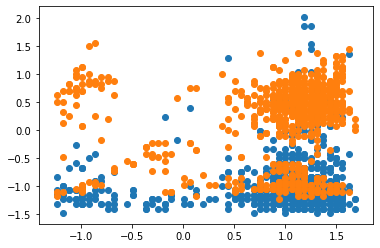

In [412]:
plt.scatter(((acoords-acoords.mean())/acoords.std())[:,2], ((bcoords-bcoords.mean())/bcoords.std())[:,0])
plt.scatter(((acoords-acoords.mean())/acoords.std())[:,2], ((acoords-acoords.mean())/acoords.std())[:,0])

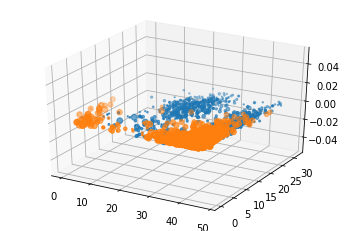

In [161]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(byargmax, brangediff, bxargmax)
plt.scatter(ayargmax, arangediff, axargmax)

In [194]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [360]:
X=np.concatenate((np.array([np.array(x) for x in list(zip(byargmax, bxaxismed, brangediff, bxargmax))]),
            np.array([np.array(x) for x in list(zip(ayargmax, axaxismed, arangediff, axargmax))])), axis=0)


In [346]:
y = np.array((len(b_data) * [2]) + (len(a_data) * [1]))

In [444]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

In [355]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [356]:
clf.predict(X_test)

array([1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
       1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1,
       1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2,
       2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 2])

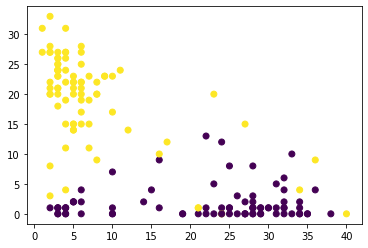

In [357]:
plt.scatter(x=X_test[:,2], y=X_test[:,1], c=clf.predict(X_test))

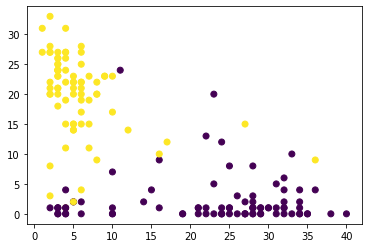

In [358]:
plt.scatter(x=X_test[:,2], y=X_test[:,1], c=y_test)

In [359]:
clf.score(X_test, y_test)

0.93125

In [517]:
X

array([[31. , 12.5, 20. , 11. ],
       [31. , 11. , 18. ,  9. ],
       [31. , 10. , 20. ,  8. ],
       ...,
       [34. , 21. ,  1. , 24. ],
       [41. , 22. ,  1. ,  3. ],
       [37. , 19. ,  1. ,  3. ]])

In [526]:
yaxis_lis=[]
xaxis_lis=[]
rangediff_lis=[]
yargmax=[]
xargmax=[]
xaxismed=[]

for img in ab_train_data:
    
    yaxis, xaxis, rangediff = get_measurements(img)
        
    yarg = yaxis.reset_index().groupby('yaxis').count().values.argmax()
    xarg = xaxis.reset_index().groupby('xaxis').count().values.argmax()
    
    yargmax.append(yarg)
    xargmax.append(xarg)
    
    yaxis_lis.append(yaxis)
    xaxis_lis.append(xaxis)
    xaxismed.append(xaxis.median())
    rangediff_lis.append(rangediff)

In [535]:
X = np.array([np.array(x) for x in list(zip(yargmax, xaxismed, rangediff_lis, xargmax))])
y = ab_train_labels

In [528]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

Mean accuracy score for L2 penalty: 0.9350625


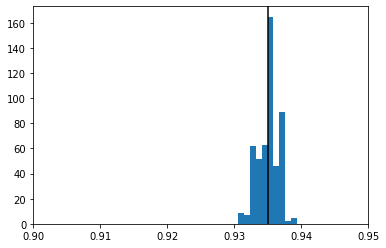

In [537]:
avg_scores_l2 = []

for i in np.arange(500):
    
    scores = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.randint(1,500))
    
    skf.get_n_splits(X,y)

    for train_index, test_index in skf.split(X2, y2):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)

        clf.predict(X_test)

        scores.append(clf.score(X_test, y_test))
        
    avg_scores_l2.append(np.mean(scores))


plt.hist(avg_scores_l2)
plt.xlim((.90,.95))
plt.axvline(np.mean(avg_scores_l2), c='black')
print("Mean accuracy score for L2 penalty:", np.mean(avg_scores_l2))

Mean accuracy score for L1 penalty: 0.93208375


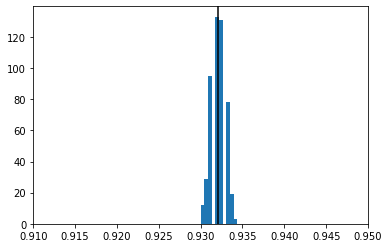

In [542]:
avg_scores_l1 = []

for i in np.arange(500):
    
    scores = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.randint(1,500))
    
    skf.get_n_splits(X,y)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train, y_train)

        clf.predict(X_test)

        scores.append(clf.score(X_test, y_test))
        
    avg_scores_l1.append(np.mean(scores))


plt.hist(avg_scores_l1)
plt.xlim((min(avg_scores_l1)-.02,min(avg_scores_l1)+.02))
plt.axvline(np.mean(avg_scores_l1), c='black')
print("Mean accuracy score for L1 penalty:", np.mean(avg_scores_l1))

Mean accuracy score for L1 penalty: 0.9320375


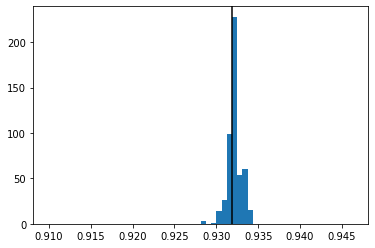

In [541]:
X = np.array([np.array(x) for x in list(zip(rangediff_lis, xargmax))])

avg_scores_2 = []

for i in np.arange(500):
    
    scores = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.randint(1,500))
    
    skf.get_n_splits(X,y)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train, y_train)

        clf.predict(X_test)

        scores.append(clf.score(X_test, y_test))
        
    avg_scores_2.append(np.mean(scores))


plt.hist(avg_scores_2)
plt.xlim((min(avg_scores_2)-.02,min(avg_scores_2)+.02))
plt.axvline(np.median(avg_scores_2), c='black')
print("Mean accuracy score for L1 penalty:", np.mean(avg_scores_2))

In [452]:
scores = []

for i in np.arange(5):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.randint(0,100))
    clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    clf.predict(X_test)
    scores.append(clf.score(X_test, y_test))

(0.8, 1.0)

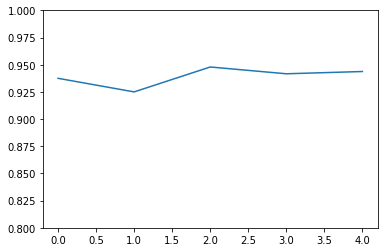

In [456]:
plt.plot(np.arange(5), scores)
plt.ylim((.80,1.0))

In [446]:
clf.predict(X_test)

array([1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1,
       2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1,
       2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2,
       1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1,
       1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1,

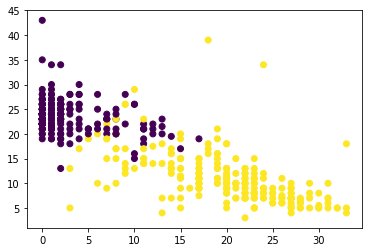

In [447]:
plt.scatter(x=X_test[:,2], y=X_test[:,1], c=clf.predict(X_test))

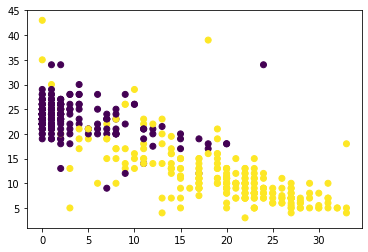

In [448]:
plt.scatter(x=X_test[:,2], y=X_test[:,1], c=y_test)

In [449]:
clf.score(X_test, y_test)

0.9333333333333333

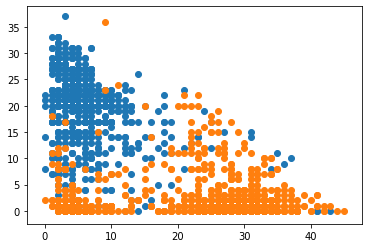

In [290]:
plt.scatter(bxargmax, brangediff)
plt.scatter(axargmax, arangediff)

In [188]:
clustering=MeanShift(bandwidth=1).fit(X)

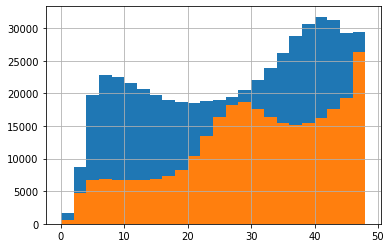

In [119]:
pd.concat(ayaxis).hist(bins=np.arange(0,50,2))
pd.concat(byaxis).hist(bins=np.arange(0,50,2))

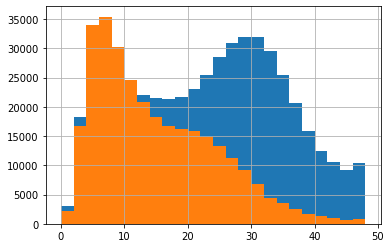

In [87]:
pd.concat(axaxis).hist(bins=np.arange(0,50,2))
pd.concat(bxaxis).hist(bins=np.arange(0,50,2))

(array([  8.,  11.,  19.,  17.,  25.,  24.,  37.,  54.,  61.,  92., 107.,
         91.,  61.,  56.,  25.,  13.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <a list of 24 Patch objects>)

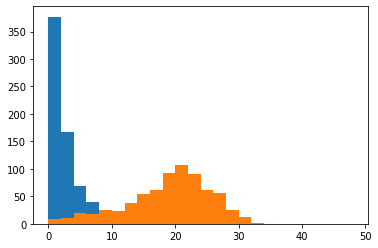

In [120]:
plt.hist(arangediff,bins=np.arange(0,50,2))
plt.hist(brangediff,bins=np.arange(0,50,2))

(array([106.,  16.,  15.,  14.,  16.,  20.,  66.,  53.,  46.,  38.]),
 array([1.00974196e-28, 4.90000000e+00, 9.80000000e+00, 1.47000000e+01,
        1.96000000e+01, 2.45000000e+01, 2.94000000e+01, 3.43000000e+01,
        3.92000000e+01, 4.41000000e+01, 4.90000000e+01]),
 <a list of 10 Patch objects>)

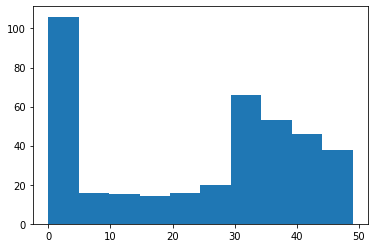

In [12]:
q = (np.array([(ab_train_data[10][i,:]*(i+1)) for i in np.arange(np.shape(ab_train_data[10])[0])]).flatten() != 0)

plt.hist(np.array([(ab_train_data[10][i,:]*(i+1)) for i in np.arange(np.shape(ab_train_data[10])[0])]).flatten()[q])

In [20]:
len(ab_train_data[10][:,1])
np.shape(ab_train_data[10])[0]

50

(array([ 1.,  2.,  0.,  9., 13.,  6.,  5.,  2.,  4.,  1.,  2.,  1.,  1.,
         0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50]),
 <a list of 25 Patch objects>)

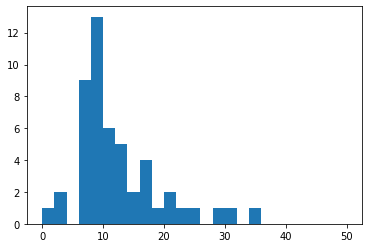

In [343]:
plt.hist([np.count_nonzero(ab_train_data[49][i,:]) for i in np.arange(50)],bins=np.arange(0,51,2))


(array([ 0.,  7.,  3., 10., 14.,  5.,  4.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50]),
 <a list of 25 Patch objects>)

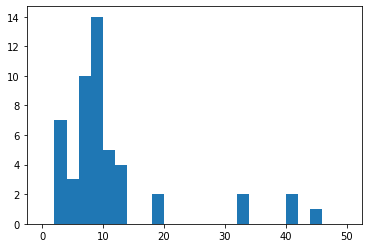

In [64]:
plt.hist([np.count_nonzero(ab_train_data[50][:,i]) for i in np.arange(50)],bins=np.arange(0,51,2))


In [293]:
b = []
a = []

for i in list(enumerate(ab_train_labels)):
    if i[1] == 2:
        b.append(i[0])
    elif i[1] == 1:
        a.append(i[0])

In [102]:
list(enumerate(ab_train_labels))[0]

(0, 1.0)

In [294]:
allb = [np.array([np.count_nonzero(ab_train_data[n][i,:]) for i in np.arange(50)]) for n in b]

In [295]:
b_data = ab_train_data[b]
a_data = ab_train_data[a]

(array([50., 80., 71., 59., 44., 42., 69., 98., 53., 45.]),
 array([1.0, 5.8, 10.6, 15.399999999999999, 20.2, 25.0, 29.799999999999997,
        34.6, 39.4, 44.199999999999996, 49.0], dtype=object),
 <a list of 10 Patch objects>)

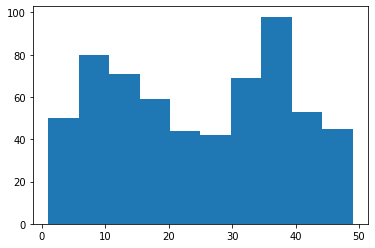

In [383]:
plt.hist(pd.Series([[i]*np.count_nonzero(a_data[10][i,:]) for i in np.arange(len(a_data[10][:,1]))]).explode())

In [393]:
[np.quantile(pd.Series([[i]*np.count_nonzero(a_data[10][i,:]) 
                       for i in np.arange(len(a_data[10][:,1]))]).explode(), .95) - np.quantile(pd.Series([[i]*np.count_nonzero(a_data[10][i,:]) 
                       for i in np.arange(len(a_data[10][:,1]))]).explode(), .05)]

[42.0]

In [395]:
[np.quantile(pd.Series([[i]*np.count_nonzero(a_data[10][:,i]) 
                       for i in np.arange(len(a_data[10][1,:]))]).explode(), .95) - np.quantile(pd.Series([[i]*np.count_nonzero(a_data[10][:,i]) 
                       for i in np.arange(len(a_data[10][1,:]))]).explode(), .05)]

[37.0]

(array([ 87.,  54.,  61.,  46.,  53.,  37., 122.,  66.,  65.,  20.]),
 array([1.0, 5.5, 10.0, 14.5, 19.0, 23.5, 28.0, 32.5, 37.0, 41.5, 46.0],
       dtype=object),
 <a list of 10 Patch objects>)

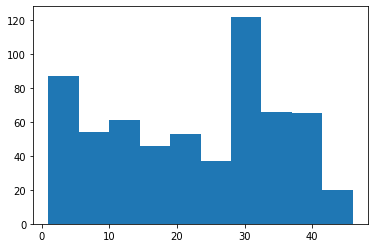

In [384]:
plt.hist(pd.Series([[i]*np.count_nonzero(a_data[10][:,i]) for i in np.arange(len(a_data[10][1,:]))]).explode())

(array([19., 22., 20., 21., 18., 37., 86., 64., 56., 47.]),
 array([0.0, 4.8, 9.6, 14.399999999999999, 19.2, 24.0, 28.799999999999997,
        33.6, 38.4, 43.199999999999996, 48.0], dtype=object),
 <a list of 10 Patch objects>)

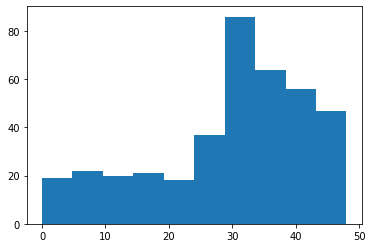

In [373]:
plt.hist(pd.Series([[i]*np.count_nonzero(b_data[10][i,:]) for i in np.arange(len(b_data[10][:,1]))]).explode())

(array([11., 36., 64., 84., 54., 34., 25., 28., 32., 22.]),
 array([0.0, 2.8, 5.6, 8.399999999999999, 11.2, 14.0, 16.799999999999997,
        19.599999999999998, 22.4, 25.2, 28.0], dtype=object),
 <a list of 10 Patch objects>)

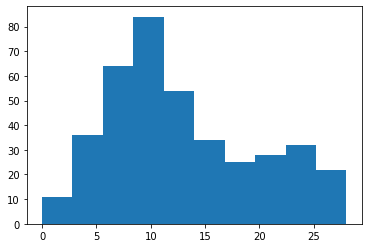

In [382]:
plt.hist(pd.Series([[i]*np.count_nonzero(b_data[10][:,i]) for i in np.arange(len(b_data[10][1,:]))]).explode())

(array([50., 80., 71., 59., 44., 42., 69., 98., 53., 45.]),
 array([1.0, 5.8, 10.6, 15.399999999999999, 20.2, 25.0, 29.799999999999997,
        34.6, 39.4, 44.199999999999996, 49.0], dtype=object),
 <a list of 10 Patch objects>)

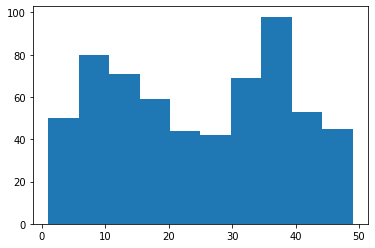

In [376]:
plt.hist(pd.Series([[i]*np.count_nonzero(a_data[10][i,:]) for i in np.arange(len(a_data[10][:,1]))]).explode())

In [396]:
[np.quantile(pd.Series([[i]*np.count_nonzero(b_data[10][i,:]) 
                       for i in np.arange(len(b_data[10][:,1]))]).explode(), .95) - np.quantile(pd.Series([[i]*np.count_nonzero(b_data[10][i,:]) 
                       for i in np.arange(len(b_data[10][:,1]))]).explode(), .05)]

[41.0]

In [397]:
[np.quantile(pd.Series([[i]*np.count_nonzero(b_data[10][:,i]) 
                       for i in np.arange(len(b_data[10][1,:]))]).explode(), .95) - np.quantile(pd.Series([[i]*np.count_nonzero(b_data[10][:,i]) 
                       for i in np.arange(len(b_data[10][1,:]))]).explode(), .05)]

[22.549999999999997]

In [317]:
datab=[pd.Series([np.count_nonzero(b_data[n][:,i]) for i in np.arange(len(b_data[n][1,:]))]) for n in np.arange(len(b))]

<BarContainer object of 50 artists>

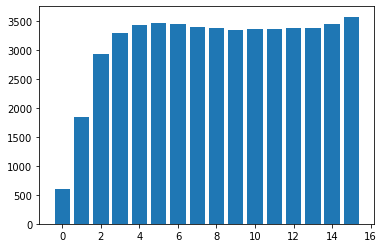

In [344]:
plt.bar(x=np.arange(50), height=(sum(datab)))

In [354]:
np.median((sum(datab)/800))
np.quantile((sum(datab)/800), .9)
(sum(datab)).values.argmax()

16

In [347]:
datab_argmax=[pd.Series([np.count_nonzero(b_data[n][:,i]) for i in np.arange(len(b_data[n][1,:]))]).values.argmax()
       for n in np.arange(len(b))]

(array([ 11., 139., 204., 156.,  82.,  68.,  35.,  21.,  15.,  20.,  12.,
          6.,  12.,   1.,   2.,   4.,   1.,   3.,   2.,   1.,   1.,   0.,
          1.,   3.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <a list of 24 Patch objects>)

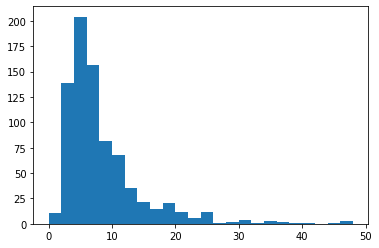

In [348]:
plt.hist(datab_argmax, bins=np.arange(0,50,2))

In [355]:
dataa=[pd.Series([np.count_nonzero(a_data[n][:,i]) for i in np.arange(len(a_data[n][1,:]))]) for 
       n in np.arange(len(a))]

<BarContainer object of 50 artists>

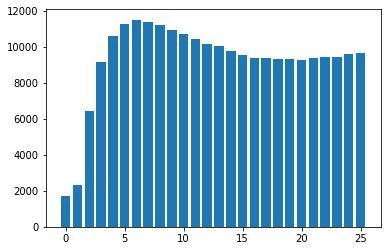

In [352]:
plt.bar(x=np.arange(50), height=(sum(dataa)))

In [353]:
np.median((sum(dataa)/800))
np.quantile((sum(dataa)/800), .9)
(sum(dataa)).values.argmax()

26

(array([ 11., 139., 204., 156.,  82.,  68.,  35.,  21.,  15.,  20.,  12.,
          6.,  12.,   1.,   2.,   4.,   1.,   3.,   2.,   1.,   1.,   0.,
          1.,   3.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <a list of 24 Patch objects>)

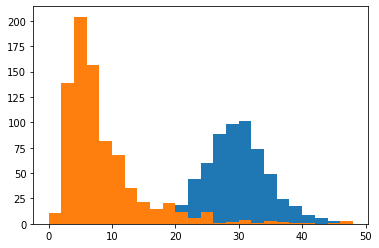

In [357]:
dataa_argmax=[pd.Series([np.count_nonzero(a_data[n][:,i]) for i in np.arange(len(a_data[n][1,:]))]).values.argmax()
       for n in np.arange(len(a))]
plt.hist(dataa_argmax, bins=np.arange(0,50,2))
plt.hist(datab_argmax, bins=np.arange(0,50,2))

In [369]:
np.count_nonzero(np.array(datab_argmax) < 5) / 800

0.31875

In [368]:
np.count_nonzero(np.array(dataa_argmax) < 5) / 800

0.085

<BarContainer object of 50 artists>

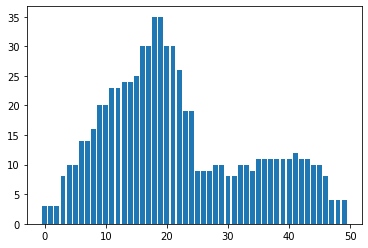

In [190]:
plt.bar(x=np.arange(0,50), height=[np.count_nonzero(b_data[0][:,i]) for i in np.arange(50)])

<BarContainer object of 50 artists>

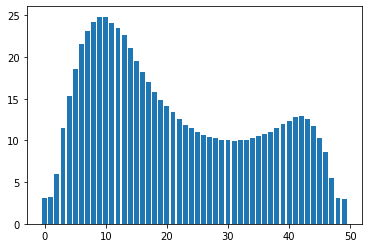

In [159]:
plt.bar(np.arange(50),pd.Series(sum(allb)).values)

<BarContainer object of 50 artists>

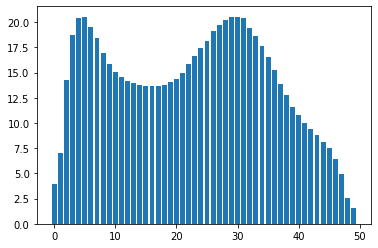

In [160]:
alla = [np.array([np.count_nonzero(ab_train_data[n][:,i])/800 for i in np.arange(50)]) for n in a]
plt.bar(np.arange(50),pd.Series(sum(alla)).values)